# Integrated Gradient

### Yonsei App. Stat
### Sunwoo Kim

### Source Paper : Sundararajan et al. Axiomatic Attribution for Deep Networks. ICML 2017  
### Source Paper Link : https://arxiv.org/abs/1703.01365

오늘 다룰 XAI 방법론은 Integrated Gradient입니다.  
Baseline으로 설정한 $x'$부터 original image $x$까지의 구간을 적분하면서,  
개별 픽셀이 output에 미치는 영향(gradient를 통해 확인)을 효과적으로 compute하는 방법론입니다.  
수식은 다음과 같습니다.

#### Original Eq. $$(x_{i} - x'_{i}) ~ \times \int^{1}_{\alpha = 0} \frac{\partial F(x' + \alpha \times (x-x'))}{\partial x_i} d\alpha $$

현실적으로 위의 적분은 intractable합니다. 따라서 논문에서 제시한 근사방법으로 적분연산을 수행하였습니다.

#### Approximation $$ \frac{(x_i - x'_{i})}{m} \times \sum^{m}_{k=1}\frac{\partial F(x' + \frac{k}{m} \times (x-x'))}{\partial x_i}$$

사용한 모델과 데이터는 다음과 같습니다.  
#### Model : Pytorch pretrained VGG19
#### Data : 
1. Cute hutsky (https://www.loveyourdog.com/siberian-husky/)
2. Cool Castle (https://www.euronews.com/travel/2021/06/28/14-castles-in-europe-that-are-straight-out-of-a-fairy-tale)
3. Awesome notebook (https://www.pocket-lint.com/laptops/reviews/apple/152137-macbook-pro-review-2020-13-inch)

또한, Imagenet 데이터의 label정보는 다음 깃헙에서 받을 수 있습니다.  
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

-------

In [1]:
# load required packages

import torch
import torchvision.models as models
from torchvision import datasets, transforms as T
import PIL
from PIL import Image

import matplotlib.pyplot as plt
from numpy import asarray
from tqdm import tqdm
import numpy as np

# Set device of a model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Call True label
import ast
file = open("imagenet_label.txt", "r")
contents = file.read()
true_label = ast.literal_eval(contents)

### A. Model and data

In [2]:
# Pretrained model
vgg19 = models.vgg19(pretrained=True)

In [3]:
husky = PIL.Image.open("test_images//hutsky.jpg")
castle = PIL.Image.open("test_images//castle.jpg")
laptop = PIL.Image.open("test_images//macbook.jpg")

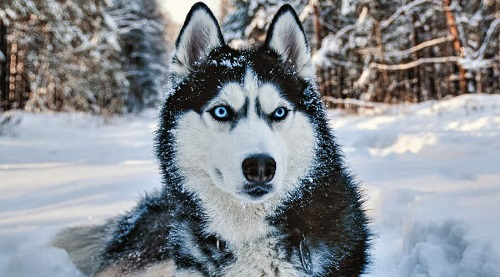

In [4]:
husky

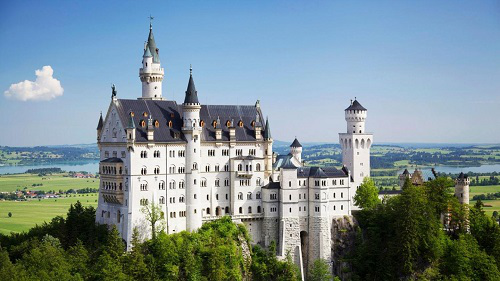

In [5]:
castle

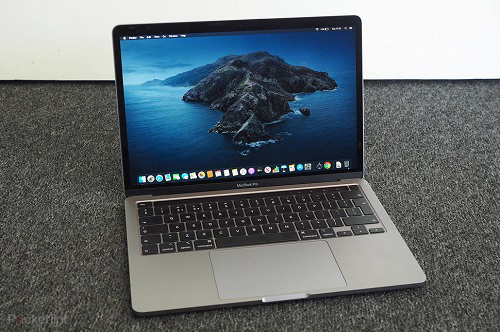

In [6]:
laptop

## B. Checking how image changes as $\alpha$ changes

이미지의 밝기를 조절하는 $\alpha$값이 변함에 따라 이미지가 어떻게 변화하는지 확인해보겠습니다.

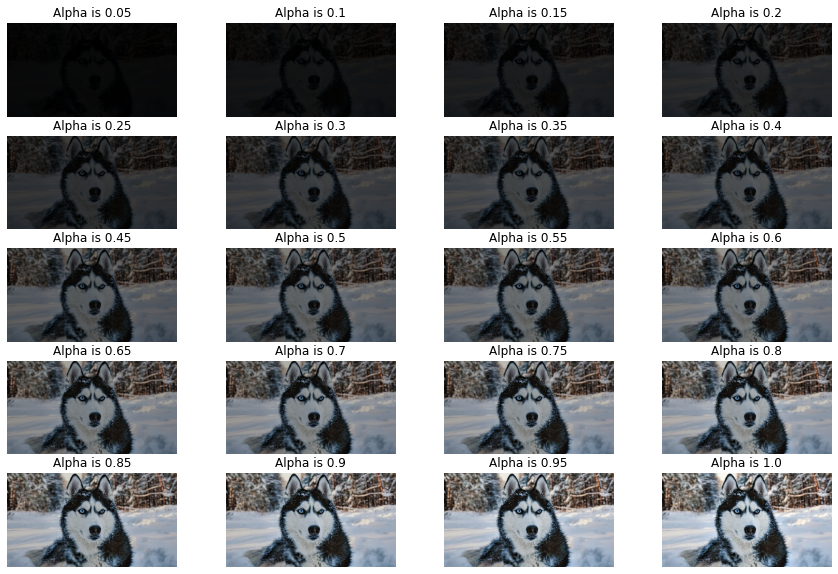

In [7]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 10))
columns = 4
rows = 5
for i in range(1, 21):
    new_img = asarray(husky)*(i/20)
    new_img = new_img.astype('uint8')
    fig.add_subplot(rows, columns, i)
    plt.imshow(new_img)
    plt.axis("off")
    plt.title("Alpha is {0}".format(i/20))
plt.show()

값이 작을수록 흐릿하며, 그 값이 커질수록 점점 선명해져 $\alpha = 1.0$일때는 원본 이미지와 동일한 것을 확인할 수 있습니다.  

이제 모델의 성능을 잠깐 체크해보겠습니다.  
모델의 accuracy가 좋아야 적절한 explanation이 가능합니다.  
각 이미지에 대한 모델의 예측을 확인해보겠습니다.

In [8]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(),
                       T.Normalize(mean=[0.0, 0.0, 0.0], std=[1, 1, 1])])

In [9]:
vgg19 = vgg19.to(device)
vgg19.eval()
for img_ in [husky, laptop, castle] : 
    outs = torch.argmax(vgg19(transform(img_).reshape(1,3, 224, 224).to(device))).to("cpu").item()
    print("Predicted label is {0}  / label {1}".format(true_label[outs], outs))

Predicted label is Siberian husky  / label 250
Predicted label is notebook, notebook computer  / label 681
Predicted label is palace  / label 698


잘 분류가 된 것을 확인할 수 있습니다.  
이제 gradient를 추출해보겠습니다.

## C. Integrated Gradient

아래와 같이 함수를 짜줍니다.  
전체 적분 구간은 300으로 나누었습니다.  
그리고 매 30회마다 prediction이 어떻게 바뀌는지 출력합니다.

In [10]:
def integrated_gradient(device, model, image, label,transformer, bins) : 
    model = model.to(device)
    model.eval()
    grad_save = torch.zeros((3, 224, 224)).to(device)
    for i in range(bins) : # Approximation of integrated gradient witt 100 bins
        prop = np.round(((i+1)/bins), 2)
        new_img = asarray(image)*prop
        new_img = new_img.astype("uint8")
        new_img = Image.fromarray(new_img, 'RGB')
        input_img = transformer(new_img)
        input_img = input_img.reshape(1, 3, 224, 224)
        input_img = input_img.to(device)
        input_img.requires_grad = True
        y_hat = model(input_img)[0, label]
        y_hat.backward()
        input_grad = input_img.grad
        grad_save += input_grad.reshape(3, 224, 224)
        if i % 30 == 0 : 
            outs = torch.argmax(model(input_img)).to("cpu").item()
            print("Current alpha : {0} / Predicted Label : {1}".format(np.round((i+1)/bins, 2), true_label[outs]))
    final_grads = grad_save.to("cpu").detach().numpy() # RGB
    return final_grads*(input_img.to("cpu").detach().numpy().reshape(3, 224, 224))/bins

In [11]:
def simple_saliency_map(device, model, image, label, transformer) : 
    model = model.to(device)
    model.eval()
    input_img = transformer(image)
    input_img = input_img.reshape(1, 3, 224, 224)
    input_img = input_img.to(device)
    input_img.requires_grad = True
    y_hat = model(input_img)[0, label]
    y_hat.backward()
    input_grad = input_img.grad.reshape(3, 224, 224)
    return input_grad.to("cpu").detach().numpy()

In [12]:
husky_grad = integrated_gradient(device = device, 
                           model = vgg19, 
                           image = husky, 
                           label = 250, 
                           transformer = transform, 
                           bins = 300)

Current alpha : 0.0 / Predicted Label : cleaver, meat cleaver, chopper
Current alpha : 0.1 / Predicted Label : nematode, nematode worm, roundworm
Current alpha : 0.2 / Predicted Label : shower cap
Current alpha : 0.3 / Predicted Label : Arctic fox, white fox, Alopex lagopus
Current alpha : 0.4 / Predicted Label : Siberian husky
Current alpha : 0.5 / Predicted Label : Siberian husky
Current alpha : 0.6 / Predicted Label : Siberian husky
Current alpha : 0.7 / Predicted Label : Siberian husky
Current alpha : 0.8 / Predicted Label : Siberian husky
Current alpha : 0.9 / Predicted Label : Siberian husky


In [13]:
cpu_grad = integrated_gradient(device = device, 
                           model = vgg19, 
                           image = laptop, 
                           label = 681, 
                           transformer = transform, 
                           bins = 300)

Current alpha : 0.0 / Predicted Label : cleaver, meat cleaver, chopper
Current alpha : 0.1 / Predicted Label : dishwasher, dish washer, dishwashing machine
Current alpha : 0.2 / Predicted Label : screen, CRT screen
Current alpha : 0.3 / Predicted Label : screen, CRT screen
Current alpha : 0.4 / Predicted Label : notebook, notebook computer
Current alpha : 0.5 / Predicted Label : notebook, notebook computer
Current alpha : 0.6 / Predicted Label : notebook, notebook computer
Current alpha : 0.7 / Predicted Label : notebook, notebook computer
Current alpha : 0.8 / Predicted Label : notebook, notebook computer
Current alpha : 0.9 / Predicted Label : notebook, notebook computer


In [14]:
castle_grad = integrated_gradient(device = device, 
                           model = vgg19, 
                           image = castle, 
                           label = 698, 
                           transformer = transform, 
                           bins = 300)

Current alpha : 0.0 / Predicted Label : cleaver, meat cleaver, chopper
Current alpha : 0.1 / Predicted Label : nematode, nematode worm, roundworm
Current alpha : 0.2 / Predicted Label : shower curtain
Current alpha : 0.3 / Predicted Label : fireboat
Current alpha : 0.4 / Predicted Label : fireboat
Current alpha : 0.5 / Predicted Label : palace
Current alpha : 0.6 / Predicted Label : palace
Current alpha : 0.7 / Predicted Label : palace
Current alpha : 0.8 / Predicted Label : palace
Current alpha : 0.9 / Predicted Label : palace


모두 초반에 이미지가 어두운 경우 다른 label을 예측하다가, 이미지가 선명해질수록 원본을 잘 예측합니다.  
이제 결과물을 시각화해보고, naive한 방법은 saliency map과 비교를 진행해보겠습니다.

In [15]:
husky_sa = simple_saliency_map(device = device, 
                           model = vgg19, 
                           image = husky, 
                           label = 250, 
                           transformer = transform)

cpu_sa = simple_saliency_map(device = device, 
                           model = vgg19, 
                           image = laptop, 
                           label = 681, 
                           transformer = transform)

castle_sa = simple_saliency_map(device = device, 
                           model = vgg19, 
                           image = castle, 
                           label = 698, 
                           transformer = transform) 

## D. Visualization

In [16]:
def showing_result(orig_image, ig, sa) : 
    fig = plt.figure(figsize=(15, 10))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(orig_image)
    plt.axis("off")
    plt.title("Original Image")
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(ig, cmap = "bone")
    plt.axis("off")
    plt.title("Integrated Gradient")
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(sa, cmap = "bone")
    plt.axis("off")
    plt.title("Saliency Map")
    
    plt.show()

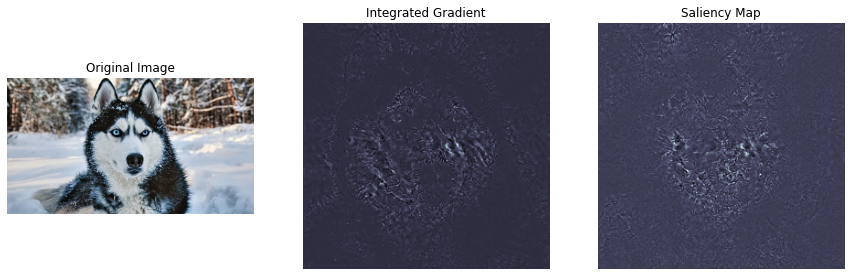

In [17]:
showing_result(husky, np.max(husky_grad, 0), np.max(husky_sa, 0))

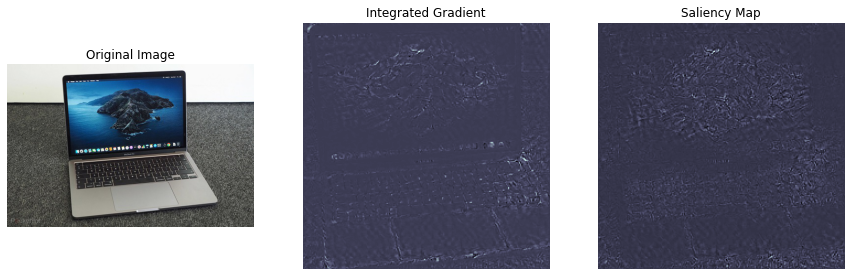

In [18]:
showing_result(laptop, np.max(cpu_grad, 0), np.max(cpu_sa, 0))

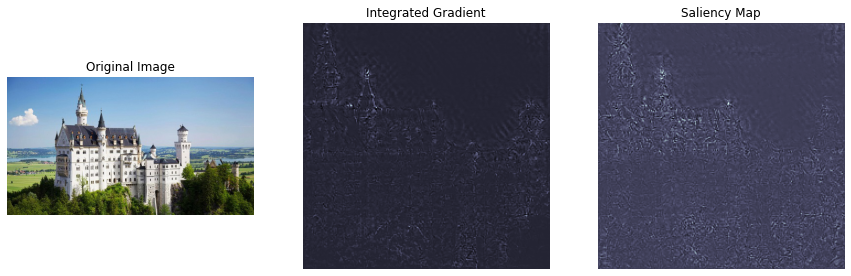

In [19]:
showing_result(castle, np.max(castle_grad, 0), np.max(castle_sa, 0))

Integrated Gradient가 SA보다 상대적으로 이미지의 윤곽과 특성을 잘 포착한것을 확인할 수 있습니다.